<a href="https://colab.research.google.com/github/grommy/NLP_in_TensorFlow/blob/master/week_4/Shakespeare-text-generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
import tensorflow.keras.regularizers as regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2019-07-24 07:09:57--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 2a00:1450:4013:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2019-07-24 07:09:58 (116 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [0]:
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Activation

In [28]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 10, 200)           160800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 200)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                50200     
_________________________________________________________________
dense_10 (Dense)             (None, 1605)              81855     
_________________________________________________________________
dense_11 (Dense)             (None, 3211)              5156866   
Total params: 5,770,821
Trainable params: 5,770,821
Non-trainable params: 0
____________________________________________

In [0]:
# Pick an optimizer
from tensorflow.keras.optimizers import Adam
adam = Adam(lr=0.01)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
from tensorflow.keras.callbacks import History, EarlyStopping, ModelCheckpoint

history_with_reg = History()
es = EarlyStopping(patience=10, monitor='acc')
mc = ModelCheckpoint("seq_model_with_reg.h5", monitor='acc', 
                     save_best_only=True, load_weights_on_restart=True)

In [31]:
model.fit(predictors, label, epochs=100, verbose=1, callbacks=[history_with_reg, mc])

Epoch 1/100
15462/15462 [==============================] - 30s 2ms/sample - loss: 6.8642 - acc: 0.0222
Epoch 2/100
15462/15462 [==============================] - 26s 2ms/sample - loss: 6.4996 - acc: 0.0210
Epoch 3/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.3848 - acc: 0.0259
Epoch 4/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.2622 - acc: 0.0291
Epoch 5/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.1769 - acc: 0.0365
Epoch 6/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.0951 - acc: 0.0377
Epoch 7/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.0170 - acc: 0.0420
Epoch 8/100
15462/15462 [==============================] - 26s 2ms/sample - loss: 5.9429 - acc: 0.0446
Epoch 9/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 5.8527 - acc: 0.0488
Epoch 10/100
15462/15462 [==============================] - 25s 2ms/sampl

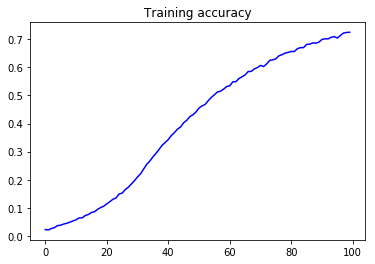

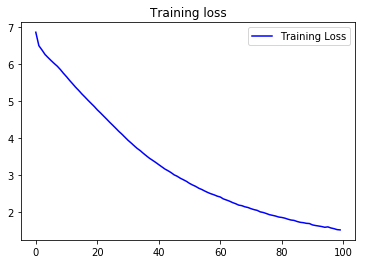

In [32]:
history = history_with_reg

import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [33]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope but his body's end skill date bettering days dead must be find their skill hour mine eyes did give prove be skill report day it green thee bright are crystal is thou art wanting wrong light torn express'd express'd bettering of 'will ' hour now still each can bring care thee still new bad still new well as it alone are you was what i i be wrought thee place nothing told sinful summer's gust may lack still more history greater state live kind shines so dear rhyme rare ride lie me days still still o'er show thee bright go
